In [120]:
import math
import pandas as pd
import tensorflow as tf
# import keras_tuner.tuners as kt
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import numpy as np
import pickle
np.random.seed(0)
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, Conv2D, LeakyReLU, MaxPool1D, AveragePooling1D, UpSampling1D, Flatten, Dense, Reshape, BatchNormalization
# https://towardsdatascience.com/improve-your-model-performance-with-auto-encoders-d4ee543b4154
from tensorflow.keras import initializers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import multivariate_normal
from keras.optimizers import Adam, SGD, Adadelta



In [121]:
x_train_scaled = pd.read_csv('../260_sample_train_scaled.csv').set_index("Patient_ID")
x_train_scaled

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                 
55_control    0.702813  0.799052  0.719665  0.729547  0.794953  0.256451   
168_CD_plain  0.751408  0.603707  0.622768  0.627712  0.606860  0.520576   
72_control    0.786508  0.755331  0.739605  0.756170  0.819875  0.391132   
120_control   0.707491  0.662993  0.648072  0.764621  0.654276  0.633929   
258_CD_plain  0.701039  0.662511  0.707208  0.834562  0.670160  0.410612   
...                ...       ...       ...       ...       ...       ...   
15_CD_plain   0.382762  0.384030  0.377332  0.360165  0.300915  0.340090   
182_CD_plain  0.679910  0.584723  0.722426  0.643867  0.740014  0.650358   
164_CD_plain  0.754656  0.556562  0.694062  0.748334  0.535534  0.133869   
53_CD_plain   0.591140  0.585802  0.750282  0.753309  0.603372  0.469634   
97_CD_plain   0.817125  0.782223  0.854442  0.867360  0.793421  0.726438   

                    C6   CEACAM7    CHI3L1     ABCC2  ...     TAF15   ZFYVE20  \
Patient_ID                                            ...                       
55_control    1.000000  0.363133  0.374212  0.611161  ...  0.468042  0.335792   
168_CD_plain  0.311962  0.251356  0.553554  0.441131  ...  0.000000  0.159464   
72_control    0.648401  0.134017  0.200420  0.679453  ...  0.335173  0.241577   
120_control   0.579519  0.248934  0.759250  0.755407  ...  0.181256  0.297248   
258_CD_plain  0.370517  0.244987  0.445387  0.798000  ...  0.319013  0.306320   
...                ...       ...       ...       ...  ...       ...       ...   
15_CD_plain   0.077348  0.890965  0.261140  0.205779  ...  0.209212  0.301844   
182_CD_plain  0.468650  0.295686  0.649939  0.609862  ...  0.408592  0.042243   
164_CD_plain  0.319071  0.154562  0.440487  0.824013  ...  0.514164  0.364434   
53_CD_plain   0.213239  0.348800  0.485094  0.722492  ...  0.428242  0.315197   
97_CD_plain   0.246396  0.228774  0.611752  0.699944  ...  0.261123  0.099541   

              LOC100420253    LY6G5B   C5orf58  RSL24D1P1     MIEN1  \
Patient_ID                                                            
55_control             0.0  0.609518  0.535456        0.0  0.543158   
168_CD_plain           0.0  0.173529  0.018188        0.0  0.623796   
72_control             0.0  0.659563  0.000000        0.0  0.853118   
120_control            0.0  0.837676  0.480372        0.0  0.392582   
258_CD_plain           0.0  0.893448  0.485539        0.0  0.259900   
...                    ...       ...       ...        ...       ...   
15_CD_plain            0.0  0.643267  0.143476        0.0  0.262892   
182_CD_plain           0.0  0.765285  0.527984        0.0  0.413798   
164_CD_plain           0.0  0.930260  0.481733        0.0  0.273699   
53_CD_plain            0.0  0.877855  0.628071        0.0  0.183718   
97_CD_plain            0.0  0.156787  0.293838        0.0  0.561414   

              PCBP1_AS1  LOC100133165  DNAJB8  
Patient_ID                                     
55_control     0.622641           0.0     1.0  
168_CD_plain   0.301179           0.0     0.0  
72_control     0.431083           0.0     0.0  
120_control    0.390569           0.0     0.0  
258_CD_plain   0.431818           0.0     0.0  
...                 ...           ...     ...  
15_CD_plain    0.189790           0.0     0.0  
182_CD_plain   0.270021           0.0     0.0  
164_CD_plain   0.433093           0.0     0.0  
53_CD_plain    0.302030           0.0     0.0  
97_CD_plain    0.027077           0.0     0.0  

[182 rows x 219 columns]

In [122]:
x_test_scaled = pd.read_csv('../260_sample_test_scaled.csv').set_index("Patient_ID")
x_test_scaled

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                      
253_CD_plain       0.869185  0.841880  0.930171  0.886737  0.835678  0.297964   
105_CD_plain       0.853562  0.933532  0.942213  0.794578  0.890482  0.206529   
2_CD_plain         0.165531  0.141475  0.263684  0.198091  0.160503  0.888878   
184_CD_plain       0.717121  0.660314  0.769417  0.752737  0.694874  0.514735   
312_CD_plain       0.730072  0.722909  0.713076  0.743545  0.679258  0.308459   
...                     ...       ...       ...       ...       ...       ...   
107_CD_plain       0.736123  0.658232  0.772323  0.685637  0.658755  0.250970   
279_CD_plain       0.220614  0.202090  0.182810  0.113245  0.105744  0.699851   
179_CD_plain       0.724476  0.726774  0.766943  0.776284  0.690339  0.380637   
70_CD_deep_ulcer   0.488321  0.495439  0.574906  0.491337  0.540073  0.525943   
256_CD_deep_ulcer  0.609459  0.598912  0.682050  0.765806  0.648350  0.450384   

                         C6   CEACAM7    CHI3L1     ABCC2  ...     TAF15  \
Patient_ID                                                 ...             
253_CD_plain       0.668498  0.266670  0.278122  0.933520  ...  0.339788   
105_CD_plain       0.298987  0.350745  0.495663  0.849038  ...  0.354602   
2_CD_plain         0.000000  0.134461  0.989132  0.202203  ...  0.320002   
184_CD_plain       0.692365  0.271127  0.650742  0.694599  ...  0.445680   
312_CD_plain       0.399235  0.129019  0.597529  0.720390  ...  0.419254   
...                     ...       ...       ...       ...  ...       ...   
107_CD_plain       0.247307  0.422075  0.555944  0.603675  ...  0.379431   
279_CD_plain       0.000000  0.908485  0.688912  0.178259  ...  0.181052   
179_CD_plain       0.440449  0.318944  0.558600  0.738787  ...  0.331961   
70_CD_deep_ulcer   0.397648  0.414520  0.709700  0.389618  ...  0.416087   
256_CD_deep_ulcer  0.000000  0.377102  0.444380  0.667302  ...  0.270050   

                    ZFYVE20  LOC100420253    LY6G5B   C5orf58  RSL24D1P1  \
Patient_ID                                                                 
253_CD_plain       0.326732           0.0  0.862246  0.074473        0.0   
105_CD_plain      -0.031527           0.0  0.717305  0.039214        0.0   
2_CD_plain         0.379134           0.0  0.604202  0.610072        0.0   
184_CD_plain       0.178908           0.0  0.702114  0.325357        0.0   
312_CD_plain       0.312215           0.0  0.821584  0.632007        0.0   
...                     ...           ...       ...       ...        ...   
107_CD_plain       0.233196           0.0  0.759342  0.567491        0.0   
279_CD_plain       0.342262           0.0  0.639644  0.540444        0.0   
179_CD_plain       0.275577           0.0  0.886616  0.658049        0.0   
70_CD_deep_ulcer   0.252402           0.0  0.931974  0.370181        0.0   
256_CD_deep_ulcer  0.268483           0.0  0.711803  0.243749        0.0   

                      MIEN1  PCBP1_AS1  LOC100133165  DNAJB8  
Patient_ID                                                    
253_CD_plain       0.498941   0.349920           0.0     0.0  
105_CD_plain       0.697073   0.268224           0.0     0.0  
2_CD_plain         0.324065   0.375123           0.0     0.0  
184_CD_plain       0.390919   0.185509           0.0     0.0  
312_CD_plain       0.183158   0.271359           0.0     0.0  
...                     ...        ...           ...     ...  
107_CD_plain       0.404604   0.190411           0.0     0.0  
279_CD_plain       0.397274   0.061934           0.0     0.0  
179_CD_plain       0.259391   0.471132           0.0     0.0  
70_CD_deep_ulcer   0.463922   0.413834           0.0     0.0  
256_CD_deep_ulcer  0.345240   0.380147           0.0     0.0  

[78 rows x 219 columns]

In [123]:
patient_ids_train = np.array(x_train_scaled.index)
patient_ids_test = np.array(x_test_scaled.index)
patient_ids_train

array(['55_control', '168_CD_plain', '72_control', '120_control',
       '258_CD_plain', '254_CD_deep_ulcer', '9_CD_plain', '111_CD_plain',
       '57_CD_plain', '216_CD_deep_ulcer', '263_CD_deep_ulcer',
       '95_CD_deep_ulcer', '31_control', '172_CD_plain', '310_CD_plain',
       '68_CD_plain', '65_control', '285_CD_plain', '201_CD_plain',
       '223_CD_deep_ulcer', '320_CD_plain', '8_CD_plain',
       '99_CD_deep_ulcer', '90_control', '296_CD_deep_ulcer',
       '219_CD_deep_ulcer', '138_CD_deep_ulcer', '38_control',
       '113_CD_plain', '76_control', '146_CD_deep_ulcer',
       '147_CD_deep_ulcer', '186_CD_plain', '158_CD_plain',
       '299_CD_plain', '178_CD_plain', '189_CD_plain', '266_CD_plain',
       '231_CD_deep_ulcer', '198_CD_plain', '6_CD_deep_ulcer',
       '30_CD_plain', '265_CD_plain', '181_CD_deep_ulcer', '16_CD_plain',
       '264_CD_deep_ulcer', '209_CD_plain', '83_control', '214_CD_plain',
       '193_CD_deep_ulcer', '104_CD_plain', '66_CD_plain', '188_CD_plain

In [124]:
def classify(x):
    if "_control" in x: # control
        return 0
    elif "CD_plain" in x: # Crohn's Disease no deep ulcer
#         print(x)
        return 1
    elif "CD_deep_ulcer" in x: # Crohn's Disease deep ulcer
#         print(x)
        return 2
    else:
        return 3 # Ulcerative Collitis

vec = np.vectorize(classify)

disease_labels_train = vec(patient_ids_train)
disease_labels_test = vec(patient_ids_test)
disease_labels_train

array([0, 1, 0, 0, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1,
       2, 0, 2, 2, 2, 0, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2,
       1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2,
       1, 2, 0, 0, 1, 2, 2, 1, 1, 2, 2, 0, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 0, 1, 1, 2,
       2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 1, 1, 1, 1])

In [125]:
compound_model = keras.models.load_model('cd_clf')

In [126]:
compound_model.summary()

## SHAP evaluation

In [127]:
x_test_scaled.iloc[:2,:2]

AADAC     APOA1
Patient_ID                      
253_CD_plain  0.869185  0.841880
105_CD_plain  0.853562  0.933532

In [128]:
import objects

In [129]:
explainer = objects.get_explainer(model=compound_model.predict, data=x_train_scaled, link="logit")

divide by zero encountered in log
Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


## Calculate SHAP values

In [130]:
# shap_values = explainer.shap_values(X=x_test_scaled)

In [131]:
# shap_values

## Save SHAP values

In [132]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [133]:


with open("../shap_values", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [134]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

## Patient-specific plots

In [136]:
idx = 0
patient = x_test_scaled.iloc[[idx],:]
patient

AADAC     APOA1    APOA4      APOB    APOC3      AQP9  \
Patient_ID                                                                    
256_CD_deep_ulcer  0.609459  0.598912  0.68205  0.765806  0.64835  0.450384   

                    C6   CEACAM7   CHI3L1     ABCC2  ...    TAF15   ZFYVE20  \
Patient_ID                                           ...                      
256_CD_deep_ulcer  0.0  0.377102  0.44438  0.667302  ...  0.27005  0.268483   

                   LOC100420253    LY6G5B   C5orf58  RSL24D1P1    MIEN1  \
Patient_ID                                                                
256_CD_deep_ulcer           0.0  0.711803  0.243749        0.0  0.34524   

                   PCBP1_AS1  LOC100133165  DNAJB8  
Patient_ID                                          
256_CD_deep_ulcer   0.380147           0.0     0.0  

[1 rows x 219 columns]

In [137]:
x_test_scaled.iloc[[0],:]

AADAC    APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                
253_CD_plain  0.869185  0.84188  0.930171  0.886737  0.835678  0.297964   

                    C6  CEACAM7    CHI3L1    ABCC2  ...     TAF15   ZFYVE20  \
Patient_ID                                          ...                       
253_CD_plain  0.668498  0.26667  0.278122  0.93352  ...  0.339788  0.326732   

              LOC100420253    LY6G5B   C5orf58  RSL24D1P1     MIEN1  \
Patient_ID                                                            
253_CD_plain           0.0  0.862246  0.074473        0.0  0.498941   

              PCBP1_AS1  LOC100133165  DNAJB8  
Patient_ID                                     
253_CD_plain    0.34992           0.0     0.0  

[1 rows x 219 columns]

In [138]:
print(f'Prediction probabilities for patient: {compound_model.predict(patient)[0]}')
print("Predicted class:")

#### Control

In [139]:
import shap

In [140]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], patient, link="logit")

####  CD no ulcer

In [141]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][idx,:], patient, link="logit")

####  CD deep ulcer

In [142]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][idx,:], patient, link="logit")

In [143]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 77
explanation = objects.get_explanation(values=shap_values[2][idx], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

_explanation.Explanation

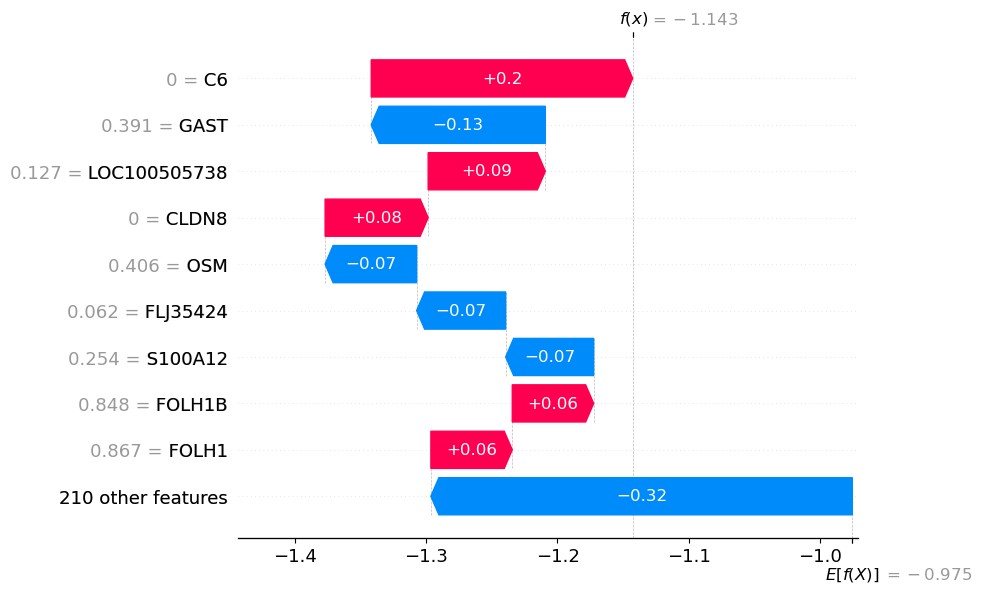

In [144]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

#### Control

In [146]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[0], shap_values[0], x_test_scaled)

####  CD no ulcer

In [26]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[1], shap_values[1], x_test_scaled)

####  CD deep ulcer

In [27]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[2], shap_values[2], x_test_scaled)

## SHAP Summary Plots

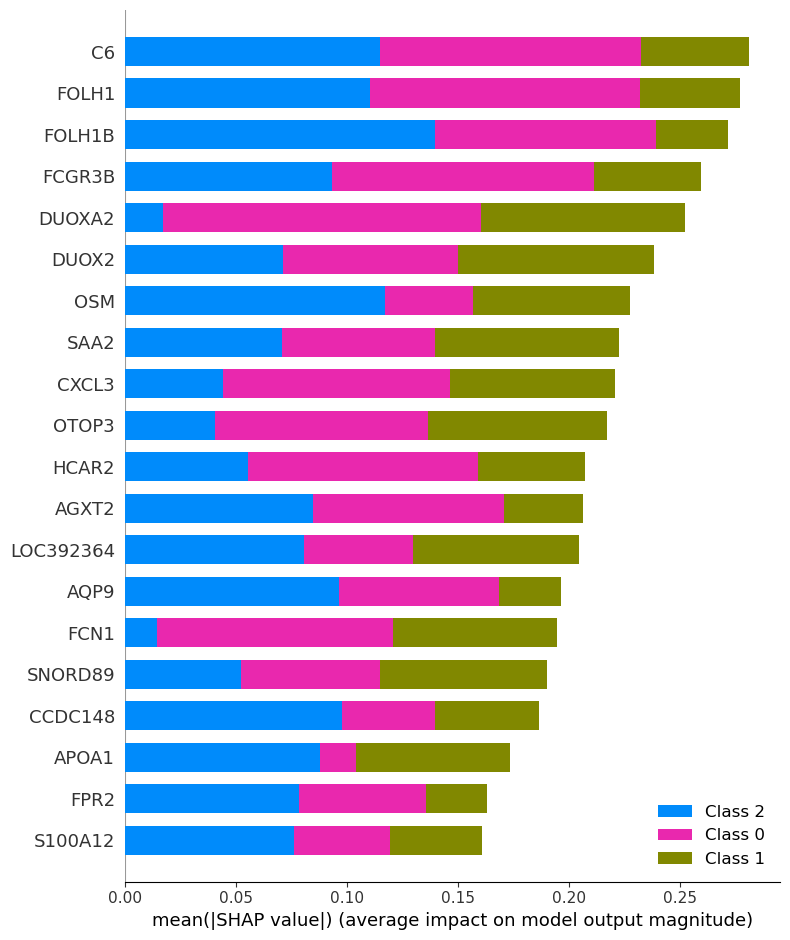

In [28]:
shap.summary_plot(shap_values, x_test_scaled)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


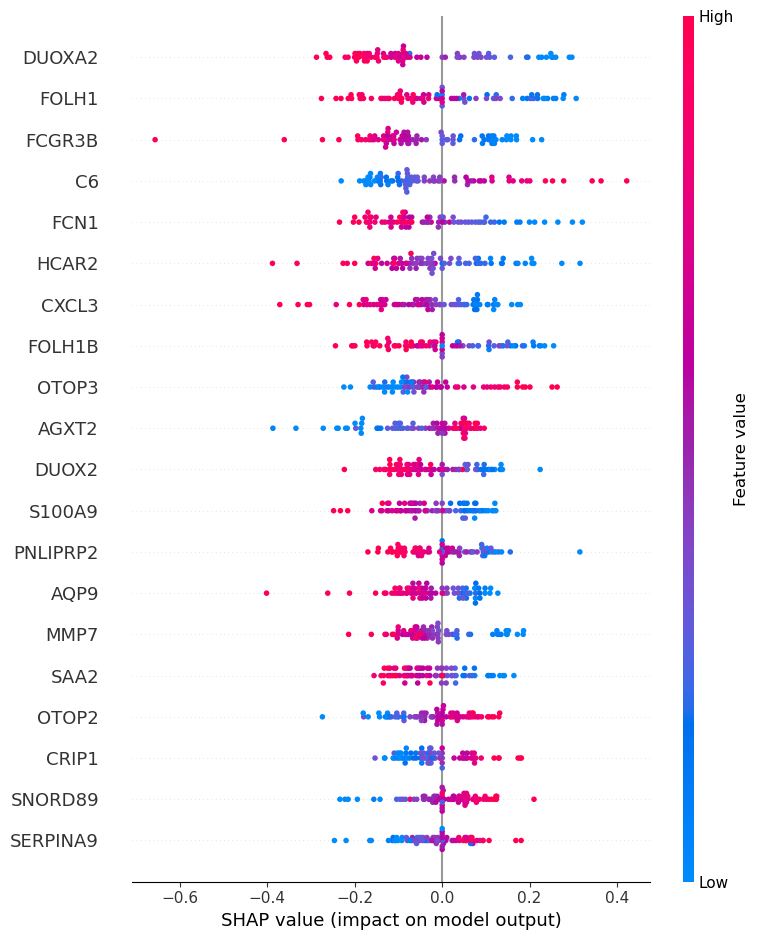

In [29]:
# control
shap.summary_plot(shap_values[0], x_test_scaled)

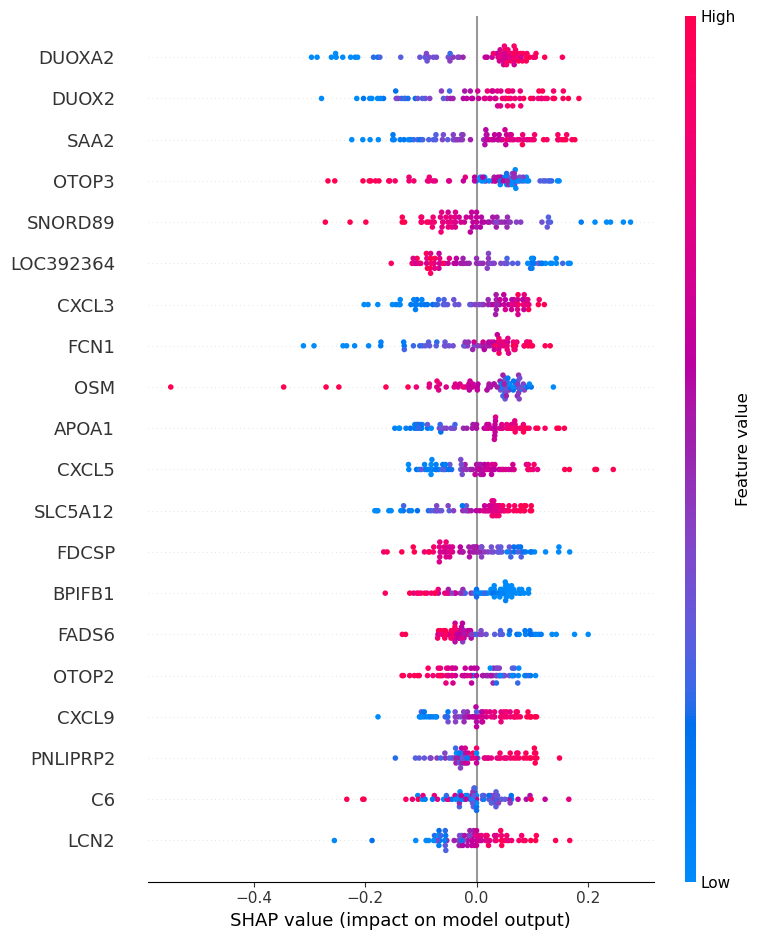

In [30]:
# CD no ulcer
shap.summary_plot(shap_values[1], x_test_scaled)

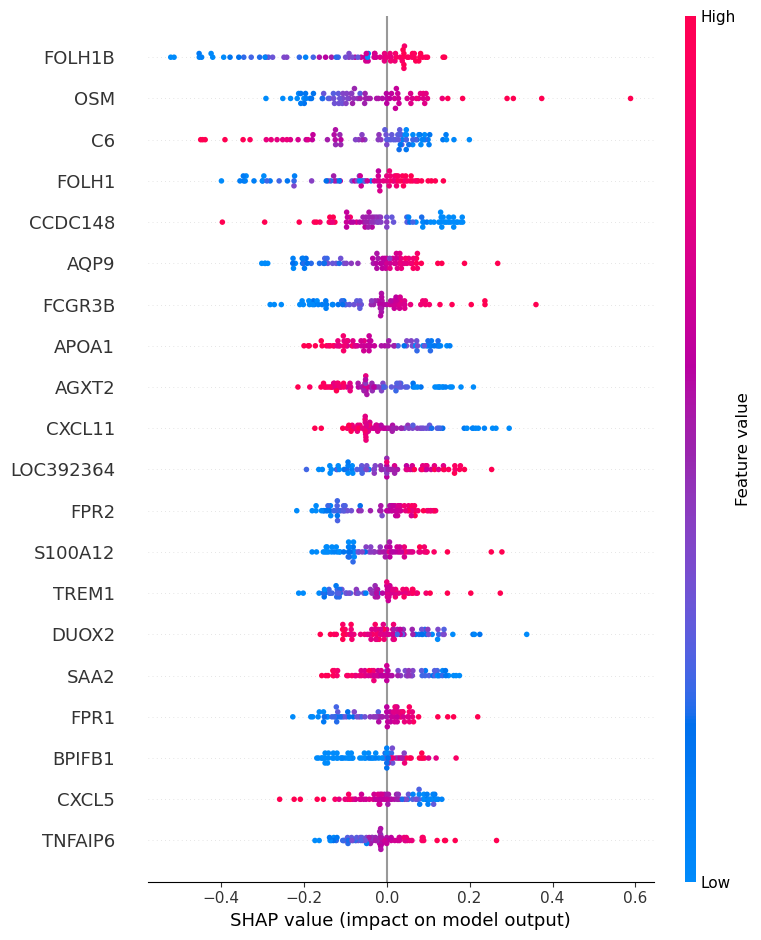

In [31]:
# CD deep ulcer
shap.summary_plot(shap_values[2], x_test_scaled)

## SHAP Dependence Plots

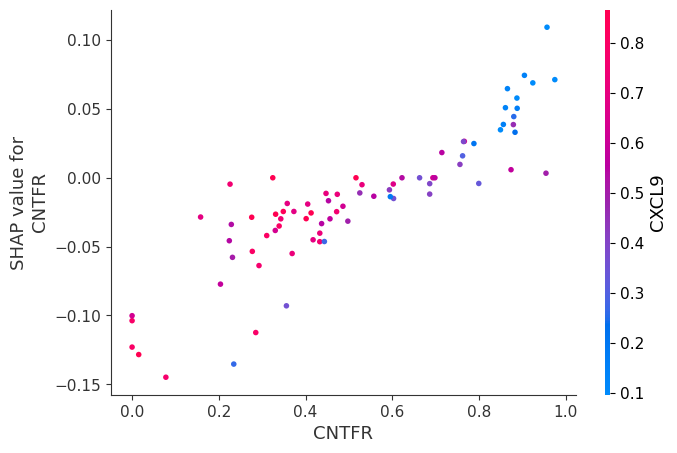

In [32]:
# control
shap.dependence_plot("CNTFR", shap_values[0], x_test_scaled)

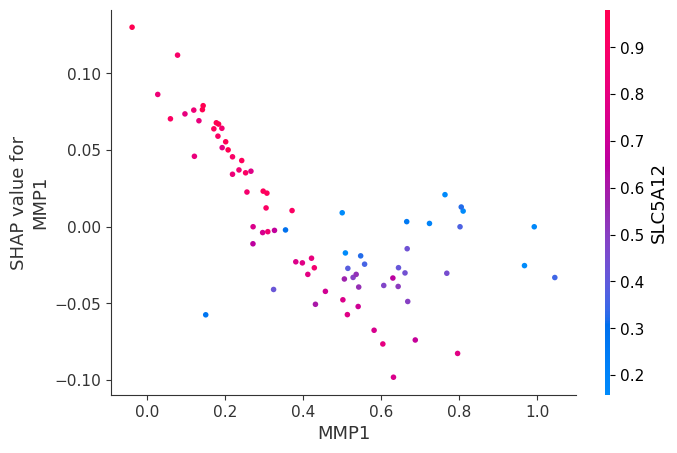

In [33]:
# CD no ulcer
shap.dependence_plot("MMP1", shap_values[1], x_test_scaled)

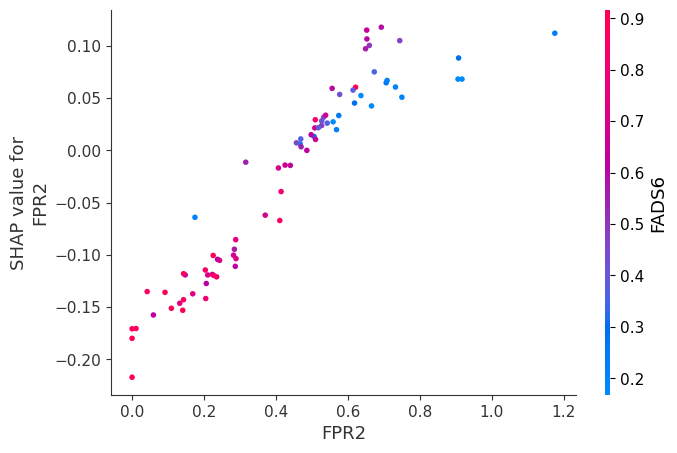

In [34]:
# CD deep ulcer
shap.dependence_plot("FPR2",shap_values[2], x_test_scaled)

## Clustering

In [35]:
disease_labels_test.shape

(78,)

In [36]:
# sys.stdout = open(1, 'w')
import sys
stdout = sys.stdout
sys.stdout = sys.__stdout__

### Current SHAP functionality

In [37]:
# clustering = objects.get_clustering(x_test_scaled, disease_labels_test)

In [38]:
# clustering

In [39]:
# clustering.shape

In [147]:
row = 77
exp = shap.Explanation(values=shap_values[2][row], base_values=explainer.expected_value[2], 
                                data=x_test_scaled.iloc[row], feature_names=x_test_scaled.columns.tolist())

# patient 8: explanations for CD deep ulcer diagnosis

In [148]:
type(exp)

shap._explanation.Explanation

In [149]:
# with open("clust", "wb") as fp:   #Pickling
#     pickle.dump(clustering, fp)

In [150]:

with open("../clust", "rb") as fp:   # Unpickling
    clustering = pickle.load(fp)

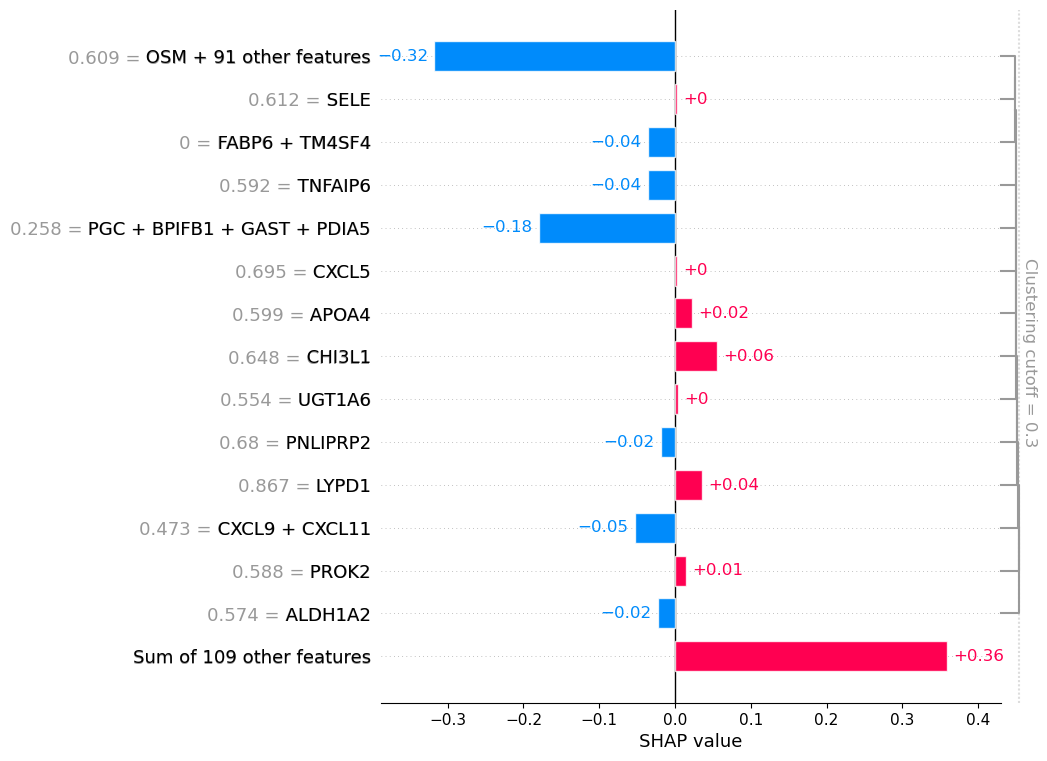

In [151]:
import shap
# shap.plots.bar(explanation, clustering=clustering)
shap.plots.bar(exp, max_display=15, clustering_cutoff=0.3,
               clustering=clustering)

## Hierarchical clustering of genes based on shap values, across all patients with given disease classification

In [45]:
from scipy.cluster.hierarchy import dendrogram, linkage, leaders, fcluster
import seaborn as sns

In [46]:


all_gene_df = pd.DataFrame(shap_values[2], index=x_test_scaled.index, columns = x_test_scaled.columns)
df_cd_deep = all_gene_df[all_gene_df.index.str.endswith('_CD_deep_ulcer')]
df_cd_plain = all_gene_df[all_gene_df.index.str.endswith('_CD_plain')]
df_control = all_gene_df[all_gene_df.index.str.endswith('_control')]
df_cd_deep

AADAC     APOA1     APOA4      APOB     APOC3      AQP9  \
Patient_ID                                                                      
62_CD_deep_ulcer  -0.003603  0.105250 -0.047044 -0.014947  0.000000  0.187628   
167_CD_deep_ulcer  0.000000  0.126500 -0.008472 -0.008706  0.006454  0.038979   
196_CD_deep_ulcer -0.015137  0.107726 -0.019753 -0.035331 -0.005677  0.071594   
23_CD_deep_ulcer  -0.008684  0.120806  0.010906  0.010129  0.008627  0.021136   
93_CD_deep_ulcer  -0.012503  0.072120  0.015956  0.025606  0.023989 -0.010768   
229_CD_deep_ulcer  0.001986 -0.029862  0.033261  0.012434  0.004867  0.043208   
46_CD_deep_ulcer  -0.018424  0.047551 -0.018109 -0.022701  0.022517  0.073889   
176_CD_deep_ulcer -0.008224 -0.041478  0.008979  0.003781  0.006723 -0.004739   
49_CD_deep_ulcer   0.031895  0.041962 -0.021250 -0.009139  0.014773 -0.114689   
183_CD_deep_ulcer  0.029745 -0.155963  0.000000  0.000000 -0.034509 -0.204027   
50_CD_deep_ulcer  -0.009465 -0.074780  0.008603  0.058560 -0.003076  0.022944   
236_CD_deep_ulcer -0.013993  0.099540  0.005353  0.000000  0.006987  0.073797   
260_CD_deep_ulcer -0.007960 -0.004720  0.024983  0.014884  0.013183  0.023237   
177_CD_deep_ulcer -0.014381  0.123826  0.002827  0.008771  0.024853  0.014520   
212_CD_deep_ulcer  0.046328 -0.120090 -0.007978  0.027060 -0.029112 -0.097709   
230_CD_deep_ulcer  0.000000  0.129818 -0.058948 -0.016899 -0.009288  0.071775   
259_CD_deep_ulcer -0.024112  0.072893 -0.024212 -0.043207 -0.024581  0.123181   
59_CD_deep_ulcer   0.000000 -0.102979  0.015951  0.029692  0.000000 -0.142367   
98_CD_deep_ulcer  -0.013884  0.106879 -0.075338 -0.033087 -0.024623  0.267737   
145_CD_deep_ulcer -0.006725  0.152192 -0.017780 -0.018444  0.017325  0.008205   
143_CD_deep_ulcer -0.016133  0.114366 -0.012075 -0.015089  0.000000  0.035538   
165_CD_deep_ulcer -0.017603  0.016709  0.022506  0.004320  0.010424  0.048794   
70_CD_deep_ulcer  -0.029188  0.061575  0.005056  0.004170  0.027500  0.000000   
256_CD_deep_ulcer -0.021647  0.004827  0.022773  0.016480  0.000000 -0.032416   

                         C6   CEACAM7    CHI3L1     ABCC2  ...     TAF15  \
Patient_ID                                                 ...             
62_CD_deep_ulcer   0.044242 -0.022843 -0.039989 -0.027093  ...  0.005510   
167_CD_deep_ulcer  0.077657 -0.009717  0.004276 -0.044046  ...  0.000000   
196_CD_deep_ulcer  0.085403 -0.028361 -0.003345 -0.070816  ...  0.006771   
23_CD_deep_ulcer   0.103641 -0.014707 -0.043298 -0.013828  ... -0.002069   
93_CD_deep_ulcer   0.062960 -0.015463 -0.005831 -0.006509  ...  0.000000   
229_CD_deep_ulcer  0.135541 -0.023186 -0.031205  0.000694  ... -0.004143   
46_CD_deep_ulcer   0.000000 -0.003175 -0.079742 -0.048241  ... -0.010020   
176_CD_deep_ulcer  0.028163 -0.021048  0.000000  0.017253  ... -0.018132   
49_CD_deep_ulcer  -0.004494  0.089633 -0.024799 -0.078440  ...  0.000000   
183_CD_deep_ulcer -0.444209 -0.098122 -0.034005  0.033140  ...  0.000000   
50_CD_deep_ulcer  -0.126935 -0.058829  0.035495  0.028110  ...  0.008815   
236_CD_deep_ulcer  0.087842 -0.022804  0.004848 -0.004157  ...  0.018236   
260_CD_deep_ulcer  0.092363 -0.019439  0.001211 -0.005056  ...  0.002224   
177_CD_deep_ulcer  0.030748 -0.020906 -0.001858 -0.029912  ... -0.013129   
212_CD_deep_ulcer -0.059822  0.053775  0.000000  0.078955  ...  0.000000   
230_CD_deep_ulcer  0.082414  0.000000 -0.069220 -0.027223  ...  0.025658   
259_CD_deep_ulcer  0.009682 -0.016590 -0.019053 -0.040029  ...  0.056264   
59_CD_deep_ulcer  -0.232493  0.075948  0.013863  0.097402  ...  0.000000   
98_CD_deep_ulcer   0.047437 -0.008453 -0.042336 -0.047980  ... -0.015191   
145_CD_deep_ulcer  0.072962 -0.017689 -0.012981 -0.033493  ... -0.026184   
143_CD_deep_ulcer  0.053223 -0.009965 -0.034876 -0.019912  ... -0.000734   
165_CD_deep_ulcer -0.110717  0.012176 -0.025675  0.007373  ... -0.017018   
70_CD_deep_ulcer  -0.018825 -0.023147 -0.010499 -0.021975  ... -0.013648   
256_CD_deep_ulc

### Example: CD deep ulcer patients

In [47]:
# patient_cluster_cd_deep = linkage(df_cd_deep, 'ward', metric='euclidean', optimal_ordering=True)
gene_cluster_cd_deep = linkage(df_cd_deep.T, 'ward', metric='euclidean', optimal_ordering=True)

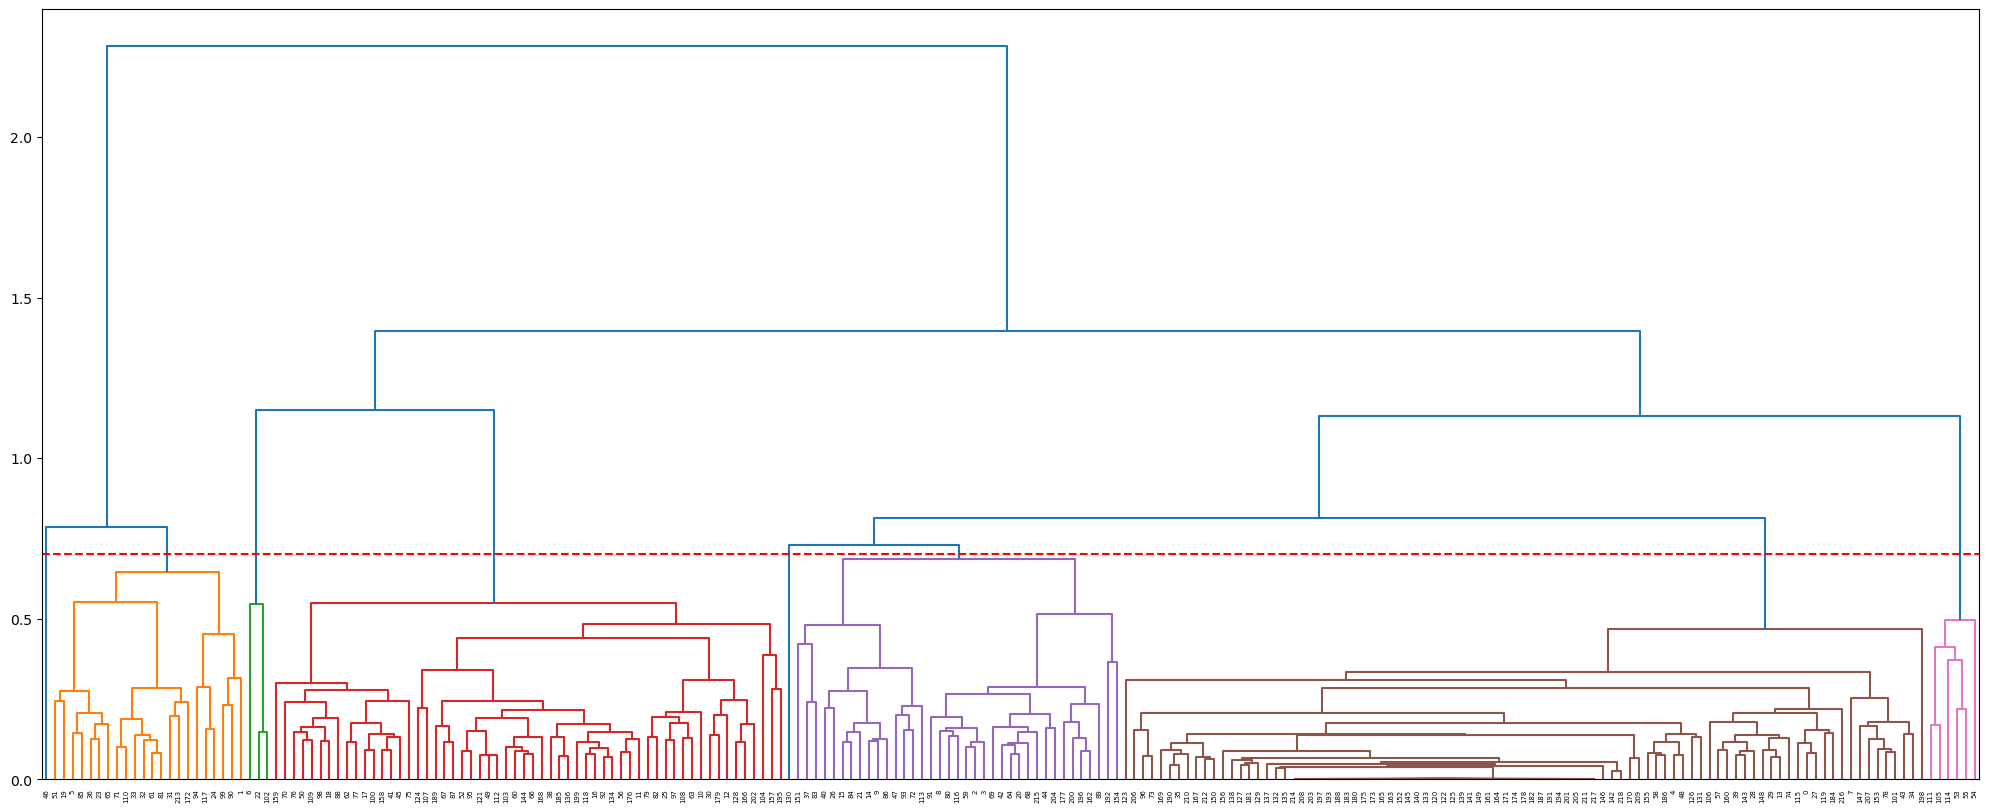

In [95]:

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_deep, color_threshold = .7, get_leaves=True)
# dn = dendrogram(fl)
plt.axhline(y=.7, c='r', linestyle='--')

In [49]:
dn_ids = np.asarray(dn['ivl'], dtype='int')
dn_ids

array([ 46,  51,  19,   5,  85,  36,  23,  65,  71, 110,  33,  32,  61,
        81,  31, 213, 172,  94, 117,  24,  99,  90,   1,   6,  22, 102,
       159,  70,  76,  50, 109,  98,  18,  88,  62,  77,  17, 100, 158,
        41,  45,  75, 124, 107, 189,  67,  87,  52,  95, 121,  49, 112,
       103,  60, 144,  66, 168,  38, 185, 136, 199, 118,  16,  92, 134,
        56, 176,  11,  79,  82,  25,  97, 108,  63,  10,  30, 179,  12,
       128, 166, 202, 104, 157, 195, 130, 151,  37,  83,  40,  26,  15,
        84,  21,  14,   9,  86,  47,  93,  72, 113,  91,   8,  80, 116,
        59,   2,   3,  69,  42,  64,  20,  68, 215,  44, 204, 177, 200,
       196, 162,  89, 192, 154, 123, 206,  96,  73, 169, 190,  35, 210,
       167, 212, 150, 156, 138, 127, 181, 129, 137, 132, 135, 214, 208,
       203, 197, 193, 188, 183, 180, 175, 173, 165, 163, 152, 145, 140,
       133, 120, 122, 125, 139, 141, 149, 161, 164, 171, 174, 178, 182,
       187, 191, 194, 201, 205, 211, 217, 146, 142, 218, 170, 20

In [50]:
df_cd_deep.columns

Index(['AADAC', 'APOA1', 'APOA4', 'APOB', 'APOC3', 'AQP9', 'C6', 'CEACAM7',
       'CHI3L1', 'ABCC2',
       ...
       'TAF15', 'ZFYVE20', 'LOC100420253', 'LY6G5B', 'C5orf58', 'RSL24D1P1',
       'MIEN1', 'PCBP1_AS1', 'LOC100133165', 'DNAJB8'],
      dtype='object', length=219)

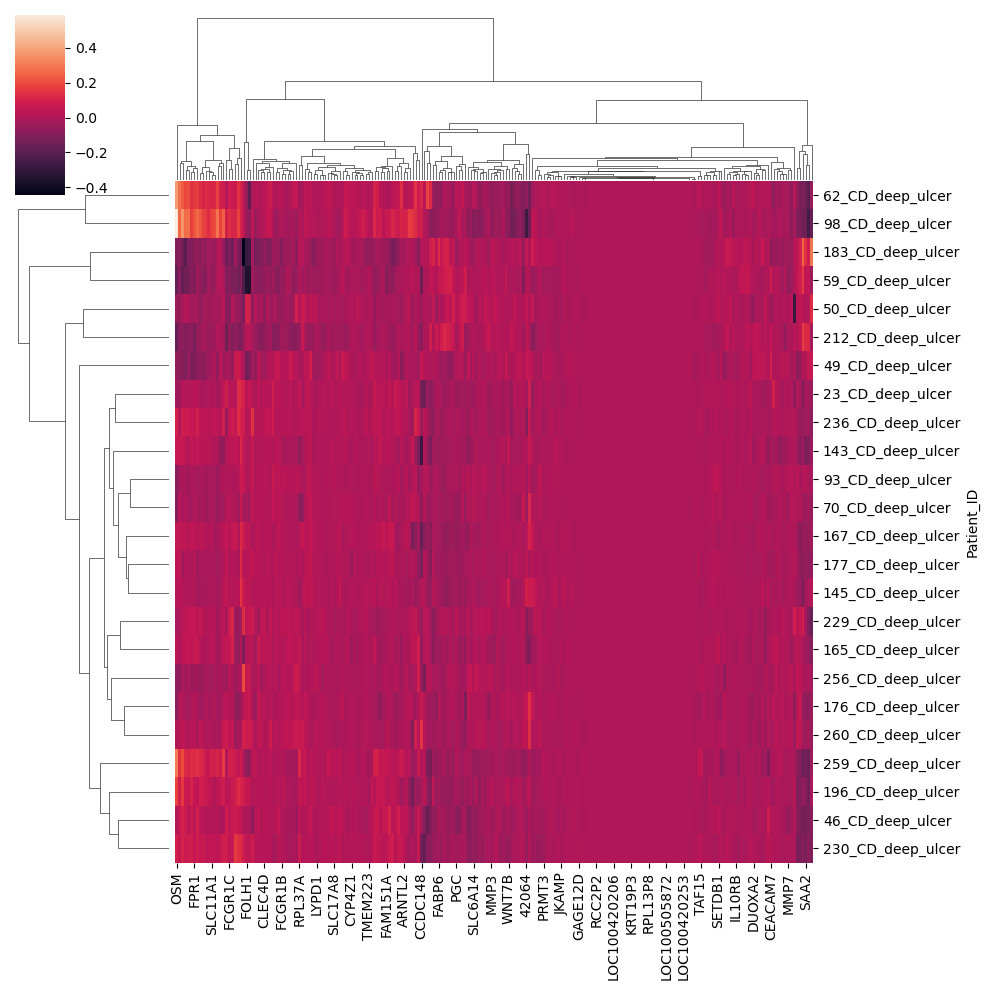

In [51]:
# shap values across genes (CD deep ulcer) - shows contribution of genes to disease symptom prediction for patients with given symptoms

# g = sns.clustermap(df_cd_deep, col_linkage=gc, row_linkage=patient_cluster_cd_deep)
g = sns.clustermap(df_cd_deep, col_linkage=gene_cluster_cd_deep)

## Aggregate bar plot, showing possible gene modules alongside SHAP contributions

In [52]:
gene_cluster_cd_deep

array([[1.20000000e+02, 1.22000000e+02, 0.00000000e+00, 2.00000000e+00],
       [2.19000000e+02, 1.25000000e+02, 0.00000000e+00, 3.00000000e+00],
       [1.33000000e+02, 2.20000000e+02, 0.00000000e+00, 4.00000000e+00],
       [2.21000000e+02, 1.39000000e+02, 0.00000000e+00, 5.00000000e+00],
       [1.40000000e+02, 2.22000000e+02, 0.00000000e+00, 6.00000000e+00],
       [2.23000000e+02, 1.41000000e+02, 0.00000000e+00, 7.00000000e+00],
       [1.45000000e+02, 2.24000000e+02, 0.00000000e+00, 8.00000000e+00],
       [2.25000000e+02, 1.49000000e+02, 0.00000000e+00, 9.00000000e+00],
       [1.52000000e+02, 2.26000000e+02, 0.00000000e+00, 1.00000000e+01],
       [2.27000000e+02, 1.61000000e+02, 0.00000000e+00, 1.10000000e+01],
       [1.63000000e+02, 2.28000000e+02, 0.00000000e+00, 1.20000000e+01],
       [2.29000000e+02, 1.64000000e+02, 0.00000000e+00, 1.30000000e+01],
       [1.65000000e+02, 2.30000000e+02, 0.00000000e+00, 1.40000000e+01],
       [2.31000000e+02, 1.71000000e+02, 0.00000000e

In [53]:
cluster_labels = fcluster(gene_cluster_cd_deep, .7, criterion='distance')
# label = fcluster(gene_cluster_cd_deep, 8, criterion='maxclust')
cluster_labels.shape

(219,)

In [54]:
leaders(gene_cluster_cd_deep, cluster_labels)

(array([ 46, 428, 425, 426, 130, 429, 420, 423], dtype=int32),
 array([2, 1, 3, 4, 6, 5, 7, 8], dtype=int32))

In [55]:
leader_ids = leaders(gene_cluster_cd_deep, cluster_labels)[1]
leader_ids

array([2, 1, 3, 4, 6, 5, 7, 8], dtype=int32)

In [56]:
cluster_labels

array([7, 1, 5, 5, 7, 1, 3, 7, 5, 5, 4, 4, 4, 7, 5, 5, 4, 4, 4, 1, 5, 5,
       3, 1, 1, 4, 5, 7, 7, 7, 4, 1, 1, 1, 7, 7, 1, 5, 4, 7, 5, 4, 5, 7,
       5, 4, 2, 5, 7, 4, 4, 1, 4, 8, 8, 8, 4, 7, 7, 5, 4, 1, 4, 4, 5, 1,
       4, 4, 5, 5, 4, 1, 5, 7, 7, 4, 4, 4, 7, 4, 5, 1, 4, 5, 5, 1, 5, 4,
       4, 5, 1, 5, 4, 5, 1, 4, 7, 4, 4, 1, 4, 7, 3, 4, 4, 8, 7, 4, 4, 4,
       1, 8, 4, 5, 8, 7, 5, 1, 4, 7, 7, 4, 7, 7, 4, 7, 7, 7, 4, 7, 6, 7,
       7, 7, 4, 7, 4, 7, 7, 7, 7, 7, 7, 7, 4, 7, 7, 7, 7, 7, 7, 5, 7, 7,
       5, 7, 7, 4, 4, 4, 7, 7, 5, 7, 7, 7, 4, 7, 4, 7, 7, 7, 1, 7, 7, 7,
       4, 5, 7, 4, 7, 7, 7, 7, 7, 4, 7, 7, 7, 4, 7, 7, 5, 7, 7, 4, 5, 7,
       7, 4, 5, 7, 4, 7, 5, 7, 7, 7, 7, 7, 7, 7, 7, 1, 7, 5, 7, 7, 7],
      dtype=int32)

In [57]:
df_cd_deep.columns.get_loc("OSM")

46

In [58]:
np.where(cluster_labels == 2) #osm

(array([46], dtype=int64),)

In [59]:
gene_df = df_cd_deep.describe().T
gene_df['gene_symbol']  = df_cd_deep.columns
gene_df["group_num"] = cluster_labels

gene_df

count      mean       std       min       25%       50%  \
AADAC          24.0 -0.005488  0.018029 -0.029188 -0.015386 -0.009074   
APOA1          24.0  0.040611  0.088382 -0.155963 -0.011005  0.066847   
APOA4          24.0 -0.005575  0.026842 -0.075338 -0.018520  0.001413   
APOB           24.0 -0.000069  0.023348 -0.043207 -0.015541  0.001891   
APOC3          24.0  0.002390  0.017107 -0.034509 -0.003726  0.005660   
...             ...       ...       ...       ...       ...       ...   
RSL24D1P1      24.0  0.000000  0.000000  0.000000  0.000000  0.000000   
MIEN1          24.0 -0.009578  0.021956 -0.047300 -0.025683 -0.007431   
PCBP1_AS1      24.0 -0.003485  0.034413 -0.111352 -0.009372  0.000000   
LOC100133165   24.0  0.000000  0.000000  0.000000  0.000000  0.000000   
DNAJB8         24.0 -0.001301  0.007393 -0.028094 -0.004291  0.000000   

                   75%       max   gene_symbol  group_num  
AADAC         0.000000  0.046328         AADAC          7  
APOA1         0.109386  0.152192         APOA1          1  
APOA4         0.012167  0.033261         APOA4          5  
APOB          0.013046  0.058560          APOB          5  
APOC3         0.013580  0.027500         APOC3          7  
...                ...       ...           ...        ...  
RSL24D1P1     0.000000  0.000000     RSL24D1P1          7  
MIEN1         0.000619  0.029404         MIEN1          5  
PCBP1_AS1     0.016011  0.073698     PCBP1_AS1          7  
LOC100133165  0.000000  0.000000  LOC100133165          7  
DNAJB8        0.002417  0.009729        DNAJB8          7  

[219 rows x 10 columns]

In [60]:
# mean_df = gene_df[['mean','group_num']]
mean_df = gene_df[['mean','group_num','gene_symbol']]
mean_df

mean  group_num   gene_symbol
AADAC        -0.005488          7         AADAC
APOA1         0.040611          1         APOA1
APOA4        -0.005575          5         APOA4
APOB         -0.000069          5          APOB
APOC3         0.002390          7         APOC3
...                ...        ...           ...
RSL24D1P1     0.000000          7     RSL24D1P1
MIEN1        -0.009578          5         MIEN1
PCBP1_AS1    -0.003485          7     PCBP1_AS1
LOC100133165  0.000000          7  LOC100133165
DNAJB8       -0.001301          7        DNAJB8

[219 rows x 3 columns]

In [61]:

mean_df["gene_symbol"] = mean_df.index
mean_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


mean  group_num   gene_symbol
AADAC        -0.005488          7         AADAC
APOA1         0.040611          1         APOA1
APOA4        -0.005575          5         APOA4
APOB         -0.000069          5          APOB
APOC3         0.002390          7         APOC3
...                ...        ...           ...
RSL24D1P1     0.000000          7     RSL24D1P1
MIEN1        -0.009578          5         MIEN1
PCBP1_AS1    -0.003485          7     PCBP1_AS1
LOC100133165  0.000000          7  LOC100133165
DNAJB8       -0.001301          7        DNAJB8

[219 rows x 3 columns]

In [62]:
def group_labels(x):
    if len(x) > 4:
        gene_list = x[:4]
    else:
        gene_list = x
    return ", ".join(gene_list)

def add_other(num, curr_label, max_display=4):
#     print(type(num))
#     print(type(curr_label))
    if num > 1:
        if num > 2: 
            other = " others" 
            num_displayed = min(num, max_display)
        else:
            num_displayed = 2
            other = " other"
        rem = num - num_displayed
        if rem == 0:
            return curr_label
        return curr_label + " + " + str(rem) + other
    else:
        return curr_label


In [63]:

def get_idx_order(dn_ids, df, agg_df):
    g_symbols = np.array(df.columns)
    g_symbols = g_symbols[dn_ids]
    
    genes_from_groups = []
    for li in agg_df["grouped_genes"].values:
        genes_from_groups.append(li[0])
        
    positions_in_dend = [np.where(g_symbols == gene)[0][0] for gene in genes_from_groups]
    idxs = np.arange(1,agg_df.shape[0]+1)
    sorted_idxs = [x for _,x in sorted(zip(positions_in_dend,idxs))]
    return sorted_idxs

In [64]:
# agg_df = mean_df.groupby(['cluster_labels']).agg([group_labels, 'sum', 'count'])
# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', list))

def group_fn(data):
    d = {}
    mean_vals = data['mean']
    symbols = list(data['gene_symbol'])
    print(mean_vals)
    print(symbols)
    mean_dict = {symbols[i]: mean_vals[i] for i in range(len(symbols))}
#     print(mean_dict)
    gene_dict = dict(sorted(mean_dict.items(), key=lambda x : x[1], reverse=True))
    gene_list = list(gene_dict.keys())
#     print(gene_list)
    d['sum'] = np.sum(data['mean'])
    d['gene_count'] = data['mean'].count()
    d['grouped_genes'] = gene_list
    return pd.Series(d)


In [65]:

agg_df = mean_df.groupby(['group_num'])
agg_df = agg_df.apply(group_fn)
agg_df

sum  gene_count  \
group_num                         
1          0.415256          22   
2          0.035662           1   
3         -0.024565           3   
4          0.332429          58   
5         -0.455450          37   
6         -0.041960           1   
7         -0.122974          91   
8         -0.195370           6   

                                               grouped_genes  
group_num                                                     
1          [APOA1, FCGR3B, SNORD89, TNFAIP6, S100A12, FPR...  
2                                                      [OSM]  
3                                        [C6, FOLH1, FOLH1B]  
4          [PPP2R5B, SUSD2, LAMC3, TCN1, RUFY4, RPL37A, F...  
5          [LRRC43, WNT7B, APOB, MMP10, NARF, FCN1, APOA4...  
6                                                  [CCDC148]  
7          [SETDB1, FNDC4, SFRP5, ELP3, CYP3A7, MDN1, ZNR...  
8            [MS4A10, LOC392364, FADS6, CXCL11, SAA2, CXCL5]

In [66]:

# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', 'mean', test))
# result = result.rename(columns={'categorize' : 'Buy/Sell'})
agg_df["cluster_labels"] = agg_df["grouped_genes"].apply(group_labels)
# agg_df["cluster_labels"] = agg_df["count"].apply(add_other)

agg_df['cluster_labels'] = agg_df.apply(lambda x: add_other(x["gene_count"], x["cluster_labels"]), axis=1)
agg_df

sum  gene_count  \
group_num                         
1          0.415256          22   
2          0.035662           1   
3         -0.024565           3   
4          0.332429          58   
5         -0.455450          37   
6         -0.041960           1   
7         -0.122974          91   
8         -0.195370           6   

                                               grouped_genes  \
group_num                                                      
1          [APOA1, FCGR3B, SNORD89, TNFAIP6, S100A12, FPR...   
2                                                      [OSM]   
3                                        [C6, FOLH1, FOLH1B]   
4          [PPP2R5B, SUSD2, LAMC3, TCN1, RUFY4, RPL37A, F...   
5          [LRRC43, WNT7B, APOB, MMP10, NARF, FCN1, APOA4...   
6                                                  [CCDC148]   
7          [SETDB1, FNDC4, SFRP5, ELP3, CYP3A7, MDN1, ZNR...   
8            [MS4A10, LOC392364, FADS6, CXCL11, SAA2, CXCL5]   

                                        cluster_labels  
group_num                                               
1          APOA1, FCGR3B, SNORD89, TNFAIP6 + 18 others  
2                                                  OSM  
3                                    C6, FOLH1, FOLH1B  
4              PPP2R5B, SUSD2, LAMC3, TCN1 + 54 others  
5               LRRC43, WNT7B, APOB, MMP10 + 33 others  
6                                              CCDC148  
7               SETDB1, FNDC4, SFRP5, ELP3 + 87 others  
8          MS4A10, LOC392364, FADS6, CXCL11 + 2 others

In [67]:
sorted_idxs = get_idx_order(dn_ids, df_cd_deep, agg_df)

In [68]:
# agg_df.index = leader_ids
agg_df.index = sorted_idxs
agg_df

sum  gene_count                                      grouped_genes  \
2  0.415256          22  [APOA1, FCGR3B, SNORD89, TNFAIP6, S100A12, FPR...   
1  0.035662           1                                              [OSM]   
3 -0.024565           3                                [C6, FOLH1, FOLH1B]   
4  0.332429          58  [PPP2R5B, SUSD2, LAMC3, TCN1, RUFY4, RPL37A, F...   
6 -0.455450          37  [LRRC43, WNT7B, APOB, MMP10, NARF, FCN1, APOA4...   
5 -0.041960           1                                          [CCDC148]   
7 -0.122974          91  [SETDB1, FNDC4, SFRP5, ELP3, CYP3A7, MDN1, ZNR...   
8 -0.195370           6    [MS4A10, LOC392364, FADS6, CXCL11, SAA2, CXCL5]   

                                cluster_labels  
2  APOA1, FCGR3B, SNORD89, TNFAIP6 + 18 others  
1                                          OSM  
3                            C6, FOLH1, FOLH1B  
4      PPP2R5B, SUSD2, LAMC3, TCN1 + 54 others  
6       LRRC43, WNT7B, APOB, MMP10 + 33 others  
5                                      CCDC148  
7       SETDB1, FNDC4, SFRP5, ELP3 + 87 others  
8  MS4A10, LOC392364, FADS6, CXCL11 + 2 others

In [69]:
agg_df = agg_df.sort_index()
agg_df

sum  gene_count                                      grouped_genes  \
1  0.035662           1                                              [OSM]   
2  0.415256          22  [APOA1, FCGR3B, SNORD89, TNFAIP6, S100A12, FPR...   
3 -0.024565           3                                [C6, FOLH1, FOLH1B]   
4  0.332429          58  [PPP2R5B, SUSD2, LAMC3, TCN1, RUFY4, RPL37A, F...   
5 -0.041960           1                                          [CCDC148]   
6 -0.455450          37  [LRRC43, WNT7B, APOB, MMP10, NARF, FCN1, APOA4...   
7 -0.122974          91  [SETDB1, FNDC4, SFRP5, ELP3, CYP3A7, MDN1, ZNR...   
8 -0.195370           6    [MS4A10, LOC392364, FADS6, CXCL11, SAA2, CXCL5]   

                                cluster_labels  
1                                          OSM  
2  APOA1, FCGR3B, SNORD89, TNFAIP6 + 18 others  
3                            C6, FOLH1, FOLH1B  
4      PPP2R5B, SUSD2, LAMC3, TCN1 + 54 others  
5                                      CCDC148  
6       LRRC43, WNT7B, APOB, MMP10 + 33 others  
7       SETDB1, FNDC4, SFRP5, ELP3 + 87 others  
8  MS4A10, LOC392364, FADS6, CXCL11 + 2 others

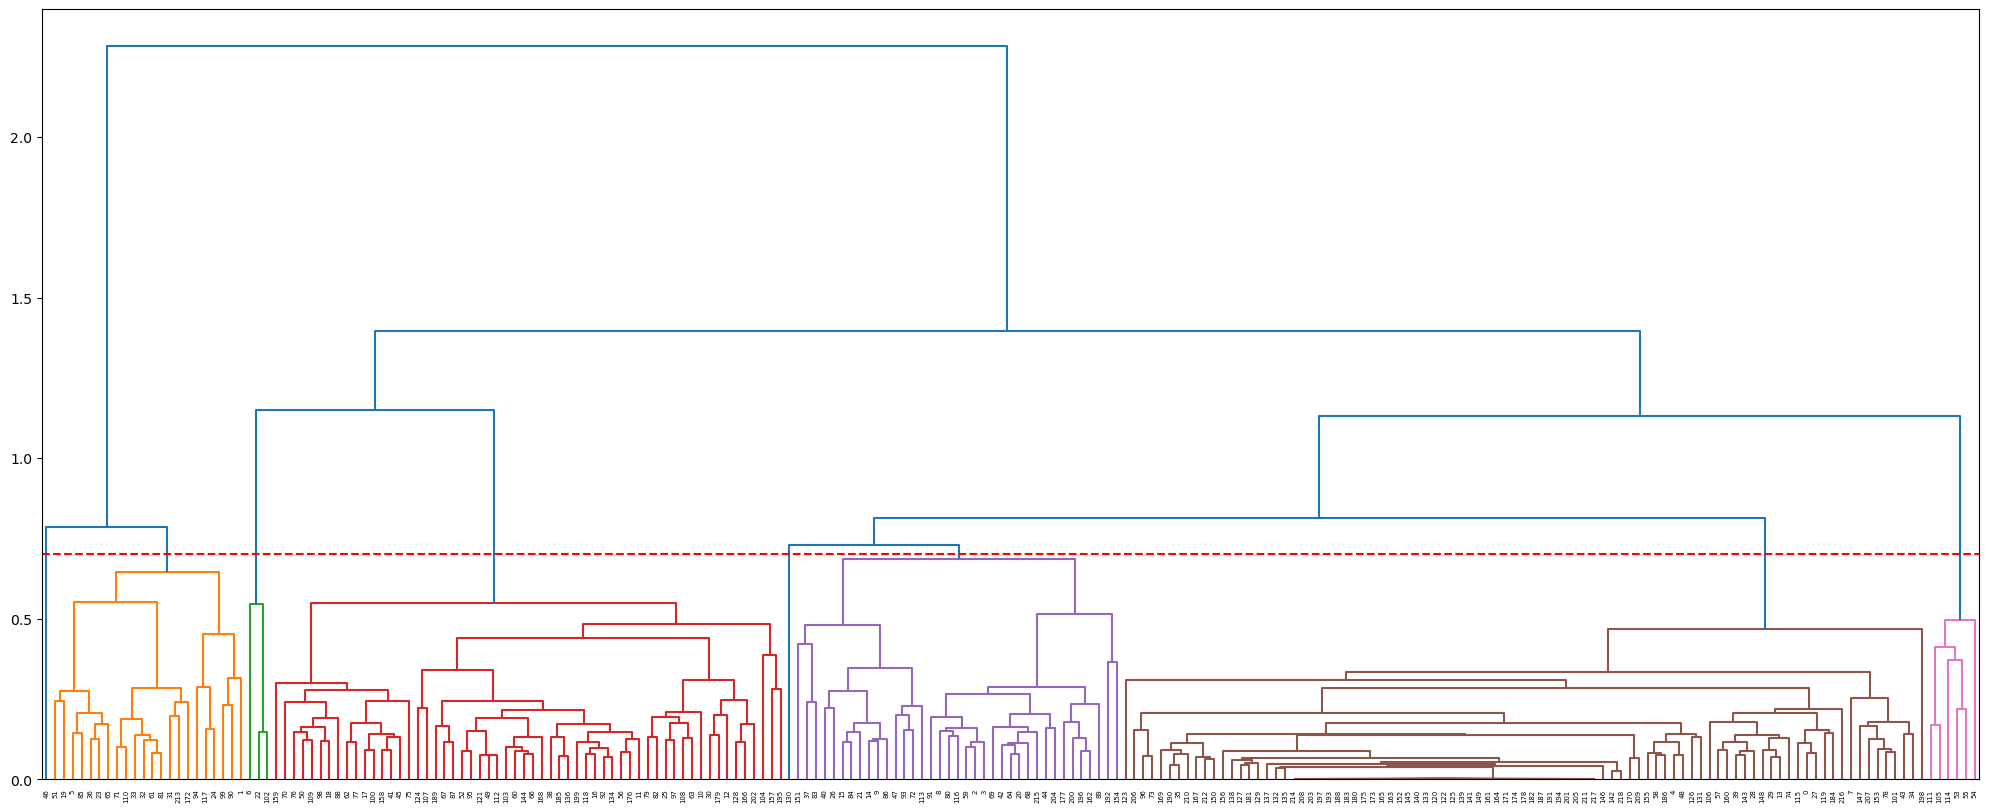

In [70]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_deep, color_threshold = 0.7)
plt.axhline(y=.7, c='r', linestyle='--')

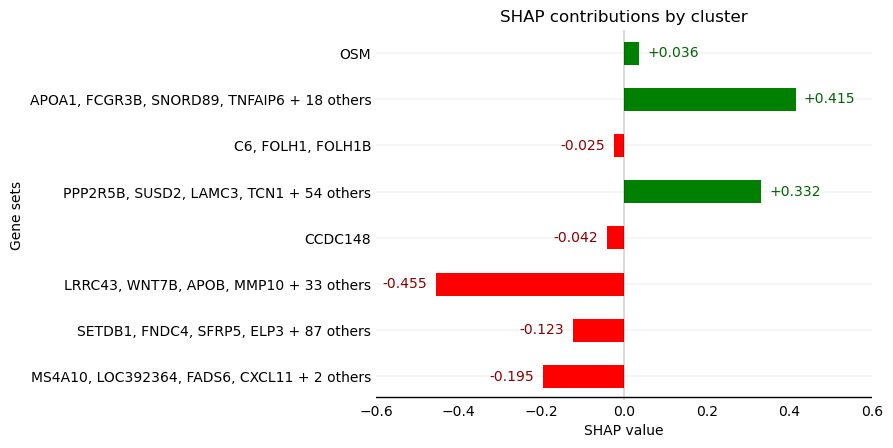

In [71]:
agg_df.plot.barh(x="cluster_labels", y="sum", legend=None, zorder=2, color=(agg_df['sum'] > 0).map({True: 'g',False: 'r'}))

plt.title('SHAP contributions by cluster')
plt.ylabel('Gene sets')
plt.xlabel('SHAP value (sum)')
plt.xlim((-.6,.6))
for i, v in enumerate(agg_df["sum"]):
    v = np.round(v, 3)
    vt = "+{:.3f}".format(v) if v >= 0 else "{:.3f}".format(v)
    offset = -.13 if v < 0 else .02
    colour = 'darkred' if v < 0 else 'darkgreen'
    plt.text(v + offset, i + .08, vt, color=colour, zorder=3)
    plt.axhline(i,linewidth=.07, color='k', zorder=1, linestyle='--')
    
    
plt.axvline(0,linewidth=.2, color='k')
plt.axhline(7.45,linewidth=1., color='k')

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.gca().invert_yaxis()
plt.box(on=False)

plt.show()

gene names shown in sorted order;
can get full lists from dataframe;
clusters correspond to above dendrogram from left to right;
can choose threshold to get more / fewer clusters

In [72]:
# export to text file

for li in agg_df["grouped_genes"]:
    print(len(li),"genes:")
    for item in li:
        print(item)
    print("----------------------")

### Example: CD no ulcer patients

In [73]:
# patient_cluster_cd_deep = linkage(df_cd_deep, 'ward', metric='euclidean', optimal_ordering=True)
gene_cluster_cd_plain = linkage(df_cd_plain.T, 'ward', metric='euclidean', optimal_ordering=True)

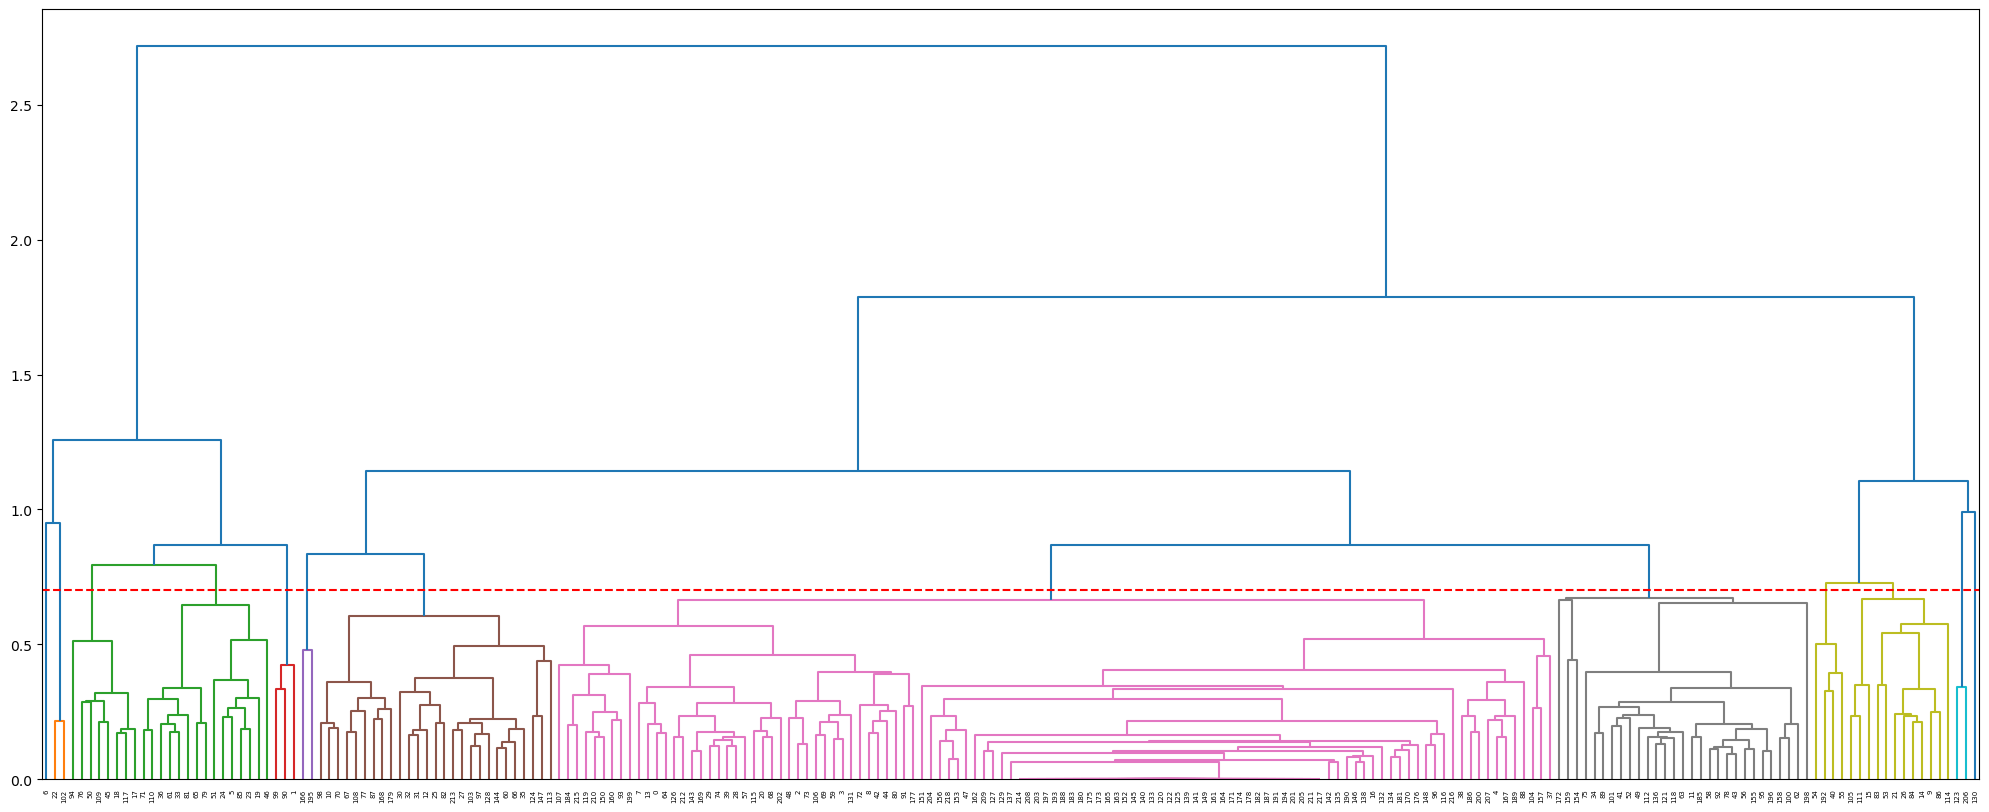

In [96]:

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_plain, color_threshold = .8)
# dn = dendrogram(fl)
plt.axhline(y=.7, c='r', linestyle='--')

In [75]:
dn_ids = np.asarray(dn['ivl'], dtype='int')
dn_ids

array([  6,  22, 102,  94,  76,  50, 109,  45,  18, 117,  17,  71, 110,
        36,  61,  33,  81,  65,  79,  51,  24,   5,  85,  23,  19,  46,
        99,  90,   1, 166, 195,  98,  10,  70,  67, 108,  77,  87, 168,
       179,  30,  32,  31,  12,  25,  82, 213,  27, 103,  97, 128, 144,
        60,  66,  35, 124, 147, 113, 107, 184, 215, 119, 210, 150, 160,
        93, 199,   7,  13,   0,  64, 126, 212, 143, 169,  29,  74,  39,
        28,  57, 115,  20,  68, 202,  48,   2,  73, 106,  69,  59,   3,
       131,  72,   8,  42,  44,  80,  91, 177, 151, 204, 156, 218, 153,
        47, 162, 209, 127, 129, 137, 214, 208, 203, 197, 193, 188, 183,
       180, 175, 173, 165, 163, 152, 145, 140, 133, 120, 122, 125, 139,
       141, 149, 161, 164, 171, 174, 178, 182, 187, 191, 194, 201, 205,
       211, 217, 142, 135, 190, 146, 138,  16, 132, 134, 181, 170, 176,
       148,  96, 116, 216,  38, 186, 200, 207,   4, 167, 189,  88, 104,
       157,  37, 172, 159, 154,  75,  34,  89, 101,  41,  52,  4

In [76]:
df_cd_plain.columns

Index(['AADAC', 'APOA1', 'APOA4', 'APOB', 'APOC3', 'AQP9', 'C6', 'CEACAM7',
       'CHI3L1', 'ABCC2',
       ...
       'TAF15', 'ZFYVE20', 'LOC100420253', 'LY6G5B', 'C5orf58', 'RSL24D1P1',
       'MIEN1', 'PCBP1_AS1', 'LOC100133165', 'DNAJB8'],
      dtype='object', length=219)

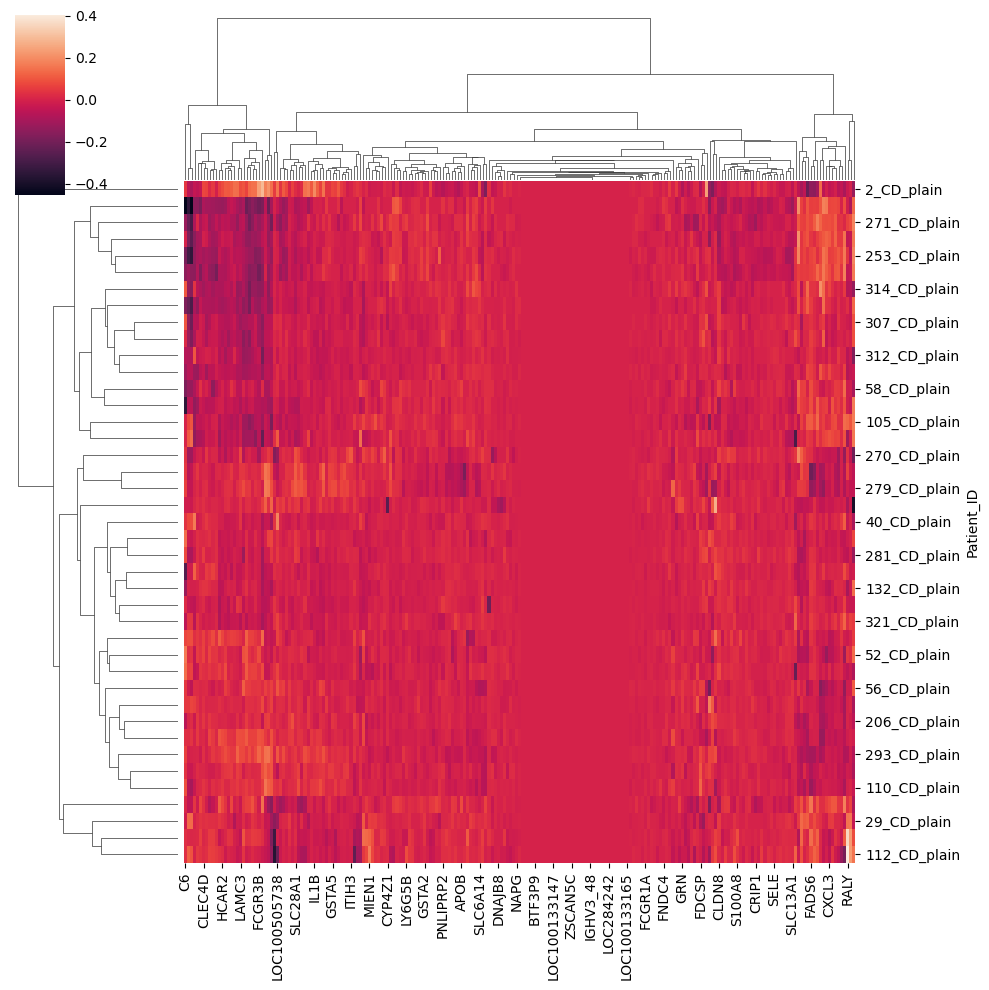

In [77]:
# shap values across genes (CD deep ulcer) - shows contribution of genes to disease symptom prediction for patients with given symptoms

# g = sns.clustermap(df_cd_deep, col_linkage=gc, row_linkage=patient_cluster_cd_deep)
g = sns.clustermap(df_cd_plain, col_linkage=gene_cluster_cd_plain)

## Aggregate bar plot, showing possible gene modules alongside SHAP contributions

In [78]:
gene_cluster_cd_plain

array([[1.20000000e+02, 1.22000000e+02, 0.00000000e+00, 2.00000000e+00],
       [2.19000000e+02, 1.25000000e+02, 0.00000000e+00, 3.00000000e+00],
       [1.33000000e+02, 2.20000000e+02, 0.00000000e+00, 4.00000000e+00],
       [2.21000000e+02, 1.39000000e+02, 0.00000000e+00, 5.00000000e+00],
       [1.40000000e+02, 2.22000000e+02, 0.00000000e+00, 6.00000000e+00],
       [2.23000000e+02, 1.41000000e+02, 0.00000000e+00, 7.00000000e+00],
       [1.45000000e+02, 2.24000000e+02, 0.00000000e+00, 8.00000000e+00],
       [2.25000000e+02, 1.49000000e+02, 0.00000000e+00, 9.00000000e+00],
       [1.52000000e+02, 2.26000000e+02, 0.00000000e+00, 1.00000000e+01],
       [2.27000000e+02, 1.61000000e+02, 0.00000000e+00, 1.10000000e+01],
       [1.63000000e+02, 2.28000000e+02, 0.00000000e+00, 1.20000000e+01],
       [2.29000000e+02, 1.64000000e+02, 0.00000000e+00, 1.30000000e+01],
       [1.65000000e+02, 2.30000000e+02, 0.00000000e+00, 1.40000000e+01],
       [2.31000000e+02, 1.71000000e+02, 0.00000000e

In [79]:
cluster_labels = fcluster(gene_cluster_cd_plain, .8, criterion='distance')
# cluster_labels = fcluster(gene_cluster_cd_plain, 8, criterion='maxclust')
cluster_labels.shape

(219,)

In [80]:
leaders(gene_cluster_cd_plain, cluster_labels)

(array([  6, 336, 426, 403, 409, 418, 421, 424, 388, 130, 425], dtype=int32),
 array([ 2,  1,  3,  4,  5,  6,  7,  8, 10, 11,  9], dtype=int32))

In [81]:
leader_ids = leaders(gene_cluster_cd_plain, cluster_labels)[1]
leader_ids

array([ 2,  1,  3,  4,  5,  6,  7,  8, 10, 11,  9], dtype=int32)

In [82]:
cluster_labels

array([ 7,  4,  7,  7,  7,  3,  2,  7,  7,  9,  6,  8,  6,  7,  9,  9,  7,
        3,  3,  3,  7,  9,  1,  3,  3,  6,  9,  6,  7,  7,  6,  6,  6,  3,
        8,  6,  3,  7,  7,  7,  9,  8,  7,  8,  7,  3,  3,  7,  7,  8,  3,
        3,  8,  9,  9,  9,  8,  7,  8,  7,  6,  3,  8,  8,  7,  3,  6,  6,
        7,  7,  6,  3,  7,  7,  7,  8,  3,  6,  8,  3,  7,  3,  6,  9,  9,
        3,  9,  6,  7,  8,  4,  7,  8,  7,  3,  8,  7,  6,  6,  4,  8,  8,
        1,  6,  7,  9,  7,  7,  6,  3,  3,  9,  8,  6,  9,  7,  7,  3,  8,
        7,  7,  8,  7, 10,  6,  7,  7,  7,  6,  7, 11,  7,  7,  7,  7,  7,
        8,  7,  7,  7,  7,  7,  7,  7,  6,  7,  7,  6,  7,  7,  7,  7,  7,
        7,  8,  8,  7,  7,  8,  8,  7,  7,  7,  7,  7,  7,  5,  7,  6,  7,
        7,  7,  8,  7,  7,  7,  7,  7,  7,  6,  7,  7,  7,  7,  7,  8,  7,
        7,  7,  7,  7,  7,  9,  7,  7,  5,  8,  7,  8,  7,  7,  7,  7,  7,
        7,  7, 10,  7,  7,  7,  7,  7,  7,  6,  7,  7,  7,  7,  7],
      dtype=int32)

In [83]:
gene_df = df_cd_plain.describe().T
gene_df['gene_symbol']  = df_cd_plain.columns
gene_df["group_num"] = cluster_labels

gene_df

count      mean       std       min       25%       50%  \
AADAC          41.0  0.009849  0.029504 -0.027933 -0.010958  0.000000   
APOA1          41.0 -0.032751  0.093708 -0.199703 -0.101865 -0.042775   
APOA4          41.0  0.006322  0.024548 -0.066842  0.000000  0.013100   
APOB           41.0  0.002073  0.033217 -0.093035 -0.011714  0.006519   
APOC3          41.0 -0.007107  0.025161 -0.083229 -0.018304  0.000000   
...             ...       ...       ...       ...       ...       ...   
RSL24D1P1      41.0  0.000000  0.000000  0.000000  0.000000  0.000000   
MIEN1          41.0  0.000367  0.040362 -0.051173 -0.021313 -0.002850   
PCBP1_AS1      41.0 -0.002300  0.038061 -0.075179 -0.017198 -0.004676   
LOC100133165   41.0  0.000000  0.000000  0.000000  0.000000  0.000000   
DNAJB8         41.0 -0.003246  0.016228 -0.093941 -0.005589  0.000000   

                   75%       max   gene_symbol  group_num  
AADAC         0.030039  0.109396         AADAC          7  
APOA1         0.059083  0.145084         APOA1          4  
APOA4         0.021554  0.049225         APOA4          7  
APOB          0.017286  0.079806          APOB          7  
APOC3         0.009851  0.023425         APOC3          7  
...                ...       ...           ...        ...  
RSL24D1P1     0.000000  0.000000     RSL24D1P1          7  
MIEN1         0.006789  0.170721         MIEN1          7  
PCBP1_AS1     0.000000  0.126567     PCBP1_AS1          7  
LOC100133165  0.000000  0.000000  LOC100133165          7  
DNAJB8        0.000000  0.018309        DNAJB8          7  

[219 rows x 10 columns]

In [84]:
# mean_df = gene_df[['mean','group_num']]
mean_df = gene_df[['mean','group_num','gene_symbol']]
mean_df

mean  group_num   gene_symbol
AADAC         0.009849          7         AADAC
APOA1        -0.032751          4         APOA1
APOA4         0.006322          7         APOA4
APOB          0.002073          7          APOB
APOC3        -0.007107          7         APOC3
...                ...        ...           ...
RSL24D1P1     0.000000          7     RSL24D1P1
MIEN1         0.000367          7         MIEN1
PCBP1_AS1    -0.002300          7     PCBP1_AS1
LOC100133165  0.000000          7  LOC100133165
DNAJB8       -0.003246          7        DNAJB8

[219 rows x 3 columns]

In [85]:

mean_df["gene_symbol"] = mean_df.index
mean_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


mean  group_num   gene_symbol
AADAC         0.009849          7         AADAC
APOA1        -0.032751          4         APOA1
APOA4         0.006322          7         APOA4
APOB          0.002073          7          APOB
APOC3        -0.007107          7         APOC3
...                ...        ...           ...
RSL24D1P1     0.000000          7     RSL24D1P1
MIEN1         0.000367          7         MIEN1
PCBP1_AS1    -0.002300          7     PCBP1_AS1
LOC100133165  0.000000          7  LOC100133165
DNAJB8       -0.003246          7        DNAJB8

[219 rows x 3 columns]

In [86]:
agg_df = mean_df.groupby(['group_num'])
agg_df = agg_df.apply(group_fn)
agg_df

sum  gene_count  \
group_num                         
1         -0.105986           2   
2         -0.021274           1   
3         -0.414138          23   
4         -0.053756           3   
5         -0.014330           2   
6         -0.113143          27   
7          0.065563         113   
8         -0.086282          29   
9          0.120766          16   
10         0.012173           2   
11         0.007563           1   

                                               grouped_genes  
group_num                                                     
1                                            [FOLH1, FOLH1B]  
2                                                       [C6]  
3          [CLEC4D, IL8, MUC1, FCGR1B, HCAR2, CLEC5A, S10...  
4                                    [SLC5A12, AGXT2, APOA1]  
5                                       [LOC100505738, CCNI]  
6          [GSTA5, FRMD6, GSTA1, CUBN, XPNPEP2, RPL37A, C...  
7          [AADAC, GAST, GRN, OTOP2, MMP3, ALDH1A2, APOA4...  
8          [LRRC43, CLDN8, SAA1, LYPD1, MMP1, MMP7, PROK2...  
9          [FADS6, FABP6, MS4A10, CXCL11, CYP3A4, SAA2, L...  
10                                             [RALY, PSME1]  
11                                                 [CCDC148]

In [87]:

# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', 'mean', test))
# result = result.rename(columns={'categorize' : 'Buy/Sell'})
agg_df["cluster_labels"] = agg_df["grouped_genes"].apply(group_labels)
# agg_df["cluster_labels"] = agg_df["count"].apply(add_other)

agg_df['cluster_labels'] = agg_df.apply(lambda x: add_other(x["gene_count"], x["cluster_labels"]), axis=1)
agg_df

sum  gene_count  \
group_num                         
1         -0.105986           2   
2         -0.021274           1   
3         -0.414138          23   
4         -0.053756           3   
5         -0.014330           2   
6         -0.113143          27   
7          0.065563         113   
8         -0.086282          29   
9          0.120766          16   
10         0.012173           2   
11         0.007563           1   

                                               grouped_genes  \
group_num                                                      
1                                            [FOLH1, FOLH1B]   
2                                                       [C6]   
3          [CLEC4D, IL8, MUC1, FCGR1B, HCAR2, CLEC5A, S10...   
4                                    [SLC5A12, AGXT2, APOA1]   
5                                       [LOC100505738, CCNI]   
6          [GSTA5, FRMD6, GSTA1, CUBN, XPNPEP2, RPL37A, C...   
7          [AADAC, GAST, GRN, OTOP2, MMP3, ALDH1A2, APOA4...   
8          [LRRC43, CLDN8, SAA1, LYPD1, MMP1, MMP7, PROK2...   
9          [FADS6, FABP6, MS4A10, CXCL11, CYP3A4, SAA2, L...   
10                                             [RALY, PSME1]   
11                                                 [CCDC148]   

                                     cluster_labels  
group_num                                            
1                                     FOLH1, FOLH1B  
2                                                C6  
3             CLEC4D, IL8, MUC1, FCGR1B + 19 others  
4                             SLC5A12, AGXT2, APOA1  
5                                LOC100505738, CCNI  
6             GSTA5, FRMD6, GSTA1, CUBN + 23 others  
7              AADAC, GAST, GRN, OTOP2 + 109 others  
8            LRRC43, CLDN8, SAA1, LYPD1 + 25 others  
9          FADS6, FABP6, MS4A10, CXCL11 + 12 others  
10                                      RALY, PSME1  
11                                          CCDC148

In [88]:
sorted_idxs = get_idx_order(dn_ids, df_cd_plain, agg_df)

In [89]:
# agg_df.index = leader_ids
agg_df.index = sorted_idxs
agg_df

sum  gene_count                                      grouped_genes  \
2  -0.105986           2                                    [FOLH1, FOLH1B]   
1  -0.021274           1                                               [C6]   
3  -0.414138          23  [CLEC4D, IL8, MUC1, FCGR1B, HCAR2, CLEC5A, S10...   
4  -0.053756           3                            [SLC5A12, AGXT2, APOA1]   
5  -0.014330           2                               [LOC100505738, CCNI]   
6  -0.113143          27  [GSTA5, FRMD6, GSTA1, CUBN, XPNPEP2, RPL37A, C...   
7   0.065563         113  [AADAC, GAST, GRN, OTOP2, MMP3, ALDH1A2, APOA4...   
8  -0.086282          29  [LRRC43, CLDN8, SAA1, LYPD1, MMP1, MMP7, PROK2...   
9   0.120766          16  [FADS6, FABP6, MS4A10, CXCL11, CYP3A4, SAA2, L...   
10  0.012173           2                                      [RALY, PSME1]   
11  0.007563           1                                          [CCDC148]   

                              cluster_labels  
2                              FOLH1, FOLH1B  
1                                         C6  
3      CLEC4D, IL8, MUC1, FCGR1B + 19 others  
4                      SLC5A12, AGXT2, APOA1  
5                         LOC100505738, CCNI  
6      GSTA5, FRMD6, GSTA1, CUBN + 23 others  
7       AADAC, GAST, GRN, OTOP2 + 109 others  
8     LRRC43, CLDN8, SAA1, LYPD1 + 25 others  
9   FADS6, FABP6, MS4A10, CXCL11 + 12 others  
10                               RALY, PSME1  
11                                   CCDC148

In [90]:
agg_df = agg_df.sort_index()
agg_df

sum  gene_count                                      grouped_genes  \
1  -0.021274           1                                               [C6]   
2  -0.105986           2                                    [FOLH1, FOLH1B]   
3  -0.414138          23  [CLEC4D, IL8, MUC1, FCGR1B, HCAR2, CLEC5A, S10...   
4  -0.053756           3                            [SLC5A12, AGXT2, APOA1]   
5  -0.014330           2                               [LOC100505738, CCNI]   
6  -0.113143          27  [GSTA5, FRMD6, GSTA1, CUBN, XPNPEP2, RPL37A, C...   
7   0.065563         113  [AADAC, GAST, GRN, OTOP2, MMP3, ALDH1A2, APOA4...   
8  -0.086282          29  [LRRC43, CLDN8, SAA1, LYPD1, MMP1, MMP7, PROK2...   
9   0.120766          16  [FADS6, FABP6, MS4A10, CXCL11, CYP3A4, SAA2, L...   
10  0.012173           2                                      [RALY, PSME1]   
11  0.007563           1                                          [CCDC148]   

                              cluster_labels  
1                                         C6  
2                              FOLH1, FOLH1B  
3      CLEC4D, IL8, MUC1, FCGR1B + 19 others  
4                      SLC5A12, AGXT2, APOA1  
5                         LOC100505738, CCNI  
6      GSTA5, FRMD6, GSTA1, CUBN + 23 others  
7       AADAC, GAST, GRN, OTOP2 + 109 others  
8     LRRC43, CLDN8, SAA1, LYPD1 + 25 others  
9   FADS6, FABP6, MS4A10, CXCL11 + 12 others  
10                               RALY, PSME1  
11                                   CCDC148

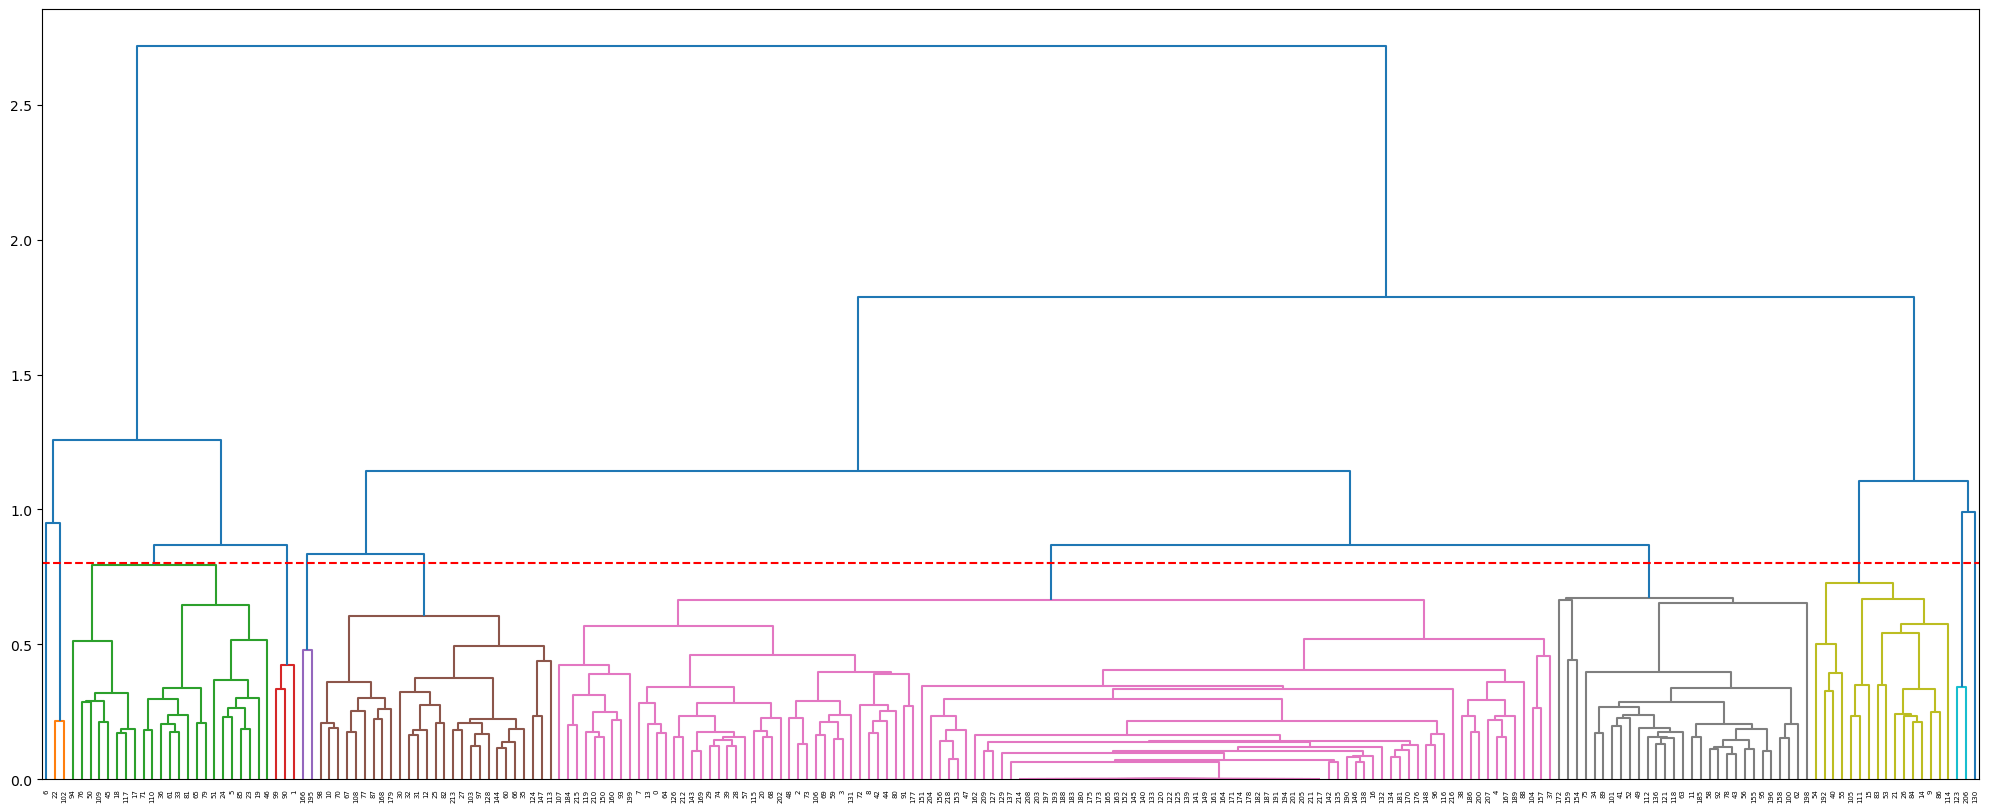

In [91]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_plain, color_threshold=.8, get_leaves=True)
plt.axhline(y=.8, c='r', linestyle='--')

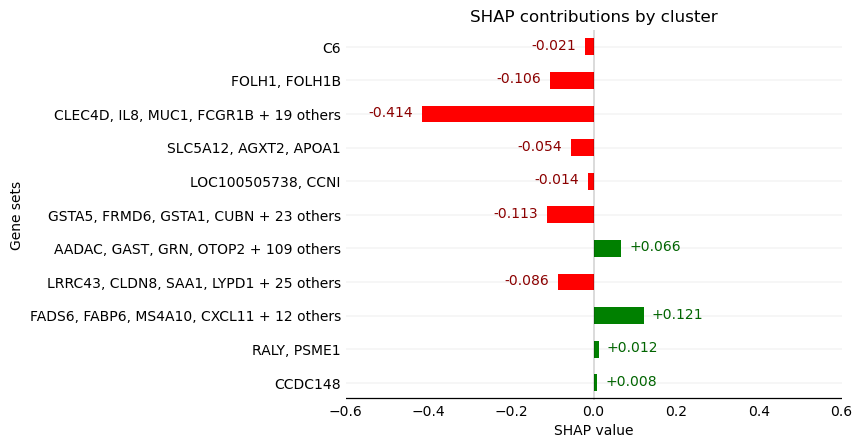

In [92]:
agg_df.plot.barh(x="cluster_labels", y="sum", legend=None, zorder=2, color=(agg_df['sum'] > 0).map({True: 'g',False: 'r'}))

plt.title('SHAP contributions by cluster')
plt.ylabel('Gene sets')
plt.xlabel('SHAP value (sum)')
plt.xlim((-.6,.6))
for i, v in enumerate(agg_df["sum"]):
    v = np.round(v, 3)
    vt = "+{:.3f}".format(v) if v >= 0 else "{:.3f}".format(v)
    offset = -.13 if v < 0 else .02
    colour = 'darkred' if v < 0 else 'darkgreen'
    plt.text(v + offset, i + .08, vt, color=colour, zorder=3)
    plt.axhline(i,linewidth=.07, color='k', zorder=1, linestyle='--')
    
    
plt.axvline(0,linewidth=.2, color='k')
size = fig.get_size_inches()[1]
plt.axhline(size + .045*size,linewidth=.9, color='k')

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.gca().invert_yaxis()
plt.box(on=False)

plt.show()

gene names shown in sorted order;
can get full lists from dataframe
clusters correspond to above dendrogram from left to right
can choose threshold to get more / fewer clusters

In [93]:
# export to text file

for li in agg_df["grouped_genes"]:
    print(len(li),"genes:")
    for item in li:
        print(item)
    print("----------------------")